In [1]:
!pip install patchify

In [40]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
import itertools
import tensorflow as tf
from matplotlib import gridspec
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from patchify import patchify
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix

In [22]:
hp = {}
hp['image_size'] = 512
hp['num_channels'] = 3
hp['patch_size'] = 64
hp['num_patches'] = (hp['image_size']**2) // (hp["patch_size"]**2)
hp["flat_patches_shape"] = (hp["num_patches"], hp['patch_size']*hp['patch_size']*hp["num_channels"])
hp['batch_size'] = 32
hp['lr'] = 1e-4
hp["num_epochs"] = 30
hp['num_classes'] = 3
hp["num_layers"] = 12
hp["hidden_dim"] = 768
hp["mlp_dim"] = 3072
hp['num_heads'] = 12
hp['dropout_rate'] = 0.1
hp['class_names'] = ["lung_aca", "lung_n", "lung_scc"]

In [4]:
train_path = "/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Train/*"
valid_path = "/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Val/*"
test_path = "/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Test/*"

model_path = "/kaggle/working/ViT_for_lung_cancer_classification.h5"
csv_path = "/kaggle/working/ViT_for_lung_cancer_classification.csv"

# Helper Function

In [5]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
def load_data(path, split=0.1):
    images = shuffle(glob(os.path.join(path, "*.jpeg")))
    return images
    

In [7]:
def process_image_label(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp['image_size'], hp['image_size']))
    image = image / 255.0
    
    patch_shape = (hp['patch_size'], hp['patch_size'], hp['num_channels'])
    patches = patchify(image, patch_shape, hp['patch_size'])
    
    #patches = np.reshape(patches, (64, 64, 64, 3))
    #for i in range(64):
    #    cv2.imwrite(f'/kaggle/working/file/image_{i}.png', patches[i])
    patches = np.reshape(patches, hp['flat_patches_shape'])
    patches = patches.astype(np.float32)
    
    #class name
    class_name = path.split("/")[-2]
    class_idx = hp['class_names'].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)
    
    return patches, class_idx

In [8]:
def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp['num_classes'])
    
    patches.set_shape(hp['flat_patches_shape'])
    labels.set_shape(hp['num_classes'])
    
    return patches, labels

In [9]:
def tf_dataset(images, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse)
    ds = ds.batch(32).prefetch(8)
    return ds

# Data Preprocessing

In [10]:
#load the data
train_x = load_data(train_path)
valid_x = load_data(valid_path)
test_x = load_data(test_path)

In [11]:
print(f'Train:{len(train_x)}  Valid:{len(valid_x)}  Test:{len(test_x)}')

Train:11250  Valid:1875  Test:1875


In [17]:
create_dir("/kaggle/working/file")

In [ ]:
process_image_label(train_x[0])

## Visualize the patches

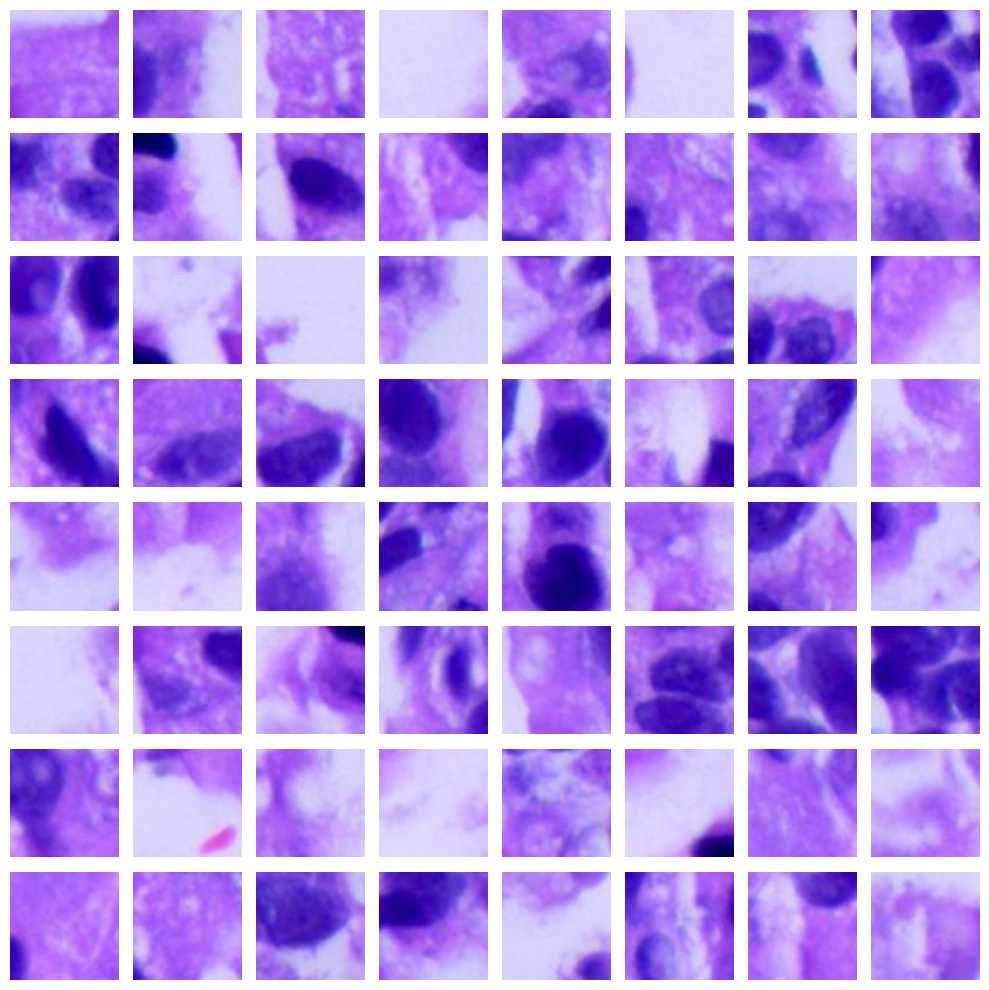

In [24]:
# Path to the folder containing your images
image_folder = "/kaggle/working/file"

# Get a list of image file names
image_files = os.listdir(image_folder)

# Create a 8x8 grid of subplots
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(8, 8)

for i, img_file in enumerate(image_files[:64]):
    # Load the image using PIL
    img_path = os.path.join(image_folder, img_file)
    img = Image.open(img_path)
    
    # Create a subplot
    ax = plt.subplot(gs[i])
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()


## Data pipeline

In [12]:
train_ds = tf_dataset(train_x, batch_size=hp['batch_size'])
valid_ds = tf_dataset(valid_x, batch_size=hp['batch_size'])
test_ds = tf_dataset(test_x, batch_size=hp['batch_size'])

In [13]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 12288), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [14]:
for i,j in train_ds:
    print(i.shape, j.shape)
    break

(32, 64, 12288) (32, 3)


# Model | ViT

In [15]:
class ClassToken(layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32), 
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        #reshape
        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        #change data type
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls   

In [16]:
def mlp(x, cf):
    x = layers.Dense(cf['mlp_dim'], activation='gelu')(x)
    x = layers.Dropout(cf['dropout_rate'])(x)
    x = layers.Dense(cf['hidden_dim'])(x)
    x = layers.Dropout(cf['dropout_rate'])(x)
    return x

In [17]:
def transformer_encoder(x, cf):
    skip_1 = x
    x = layers.LayerNormalization()(x)
    x = layers.MultiHeadAttention(num_heads=cf['num_heads'], key_dim=cf['hidden_dim'])(x,x)
    x = layers.Add()([x, skip_1])
    
    skip_2 = x
    x = layers.LayerNormalization()(x)
    x = mlp(x, cf)
    x = layers.Add()([x, skip_2])
    
    return x

In [18]:
def ViT(cf):
    input_shape = (cf['num_patches'], cf['patch_size']*cf['patch_size']*cf['num_channels'])
    inputs = layers.Input(input_shape) #(None, 256, 3072)
    
    #patch + Position embedding
    patch_embed = layers.Dense(cf['hidden_dim'])(inputs) #(None, 256, 768)
    
    positions = tf.range(start=0, limit=cf['num_patches'], delta=1)
    pos_emb = layers.Embedding(input_dim=cf['num_patches'], output_dim=cf['hidden_dim'])(positions) #(256, 768)
    
    embed = patch_embed + pos_emb #(None, 256, 768)
    
    token = ClassToken()(embed)
    x = layers.Concatenate(axis=1)([token, embed]) #(None, 257, 768)
    
    for _ in range(cf['num_layers']):
        x = transformer_encoder(x, cf)
        
    x = layers.LayerNormalization()(x)
    x = x[:, 0, :]
    x = layers.Dense(cf['num_classes'], activation='softmax')(x)
    
    model = Model(inputs, x)
    return model

In [19]:
model = ViT(hp)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 12288)]  0           []                               
                                                                                                  
 dense (Dense)                  (None, 64, 768)      9437952     ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 64, 768)     0           ['dense[0][0]']                  
 da)                                                                                              
                                                                                                  
 class_token (ClassToken)       (None, 1, 768)       768         ['tf.__operators__.add[0][0]'

In [20]:
model.compile(loss='categorical_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(hp['lr'], clipvalue=1.0),
              metrics=['acc']
             )

In [21]:
cbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7),
    tf.keras.callbacks.CSVLogger(csv_path),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
]

# Training

In [42]:
model.fit(
        train_ds,
        epochs=20,
        validation_data=valid_ds,
        callbacks=cbacks
    )

Epoch 1/20
352/352 [==============================] - ETA: 0s - loss: 0.1020 - acc: 0.9610
Epoch 1: val_loss did not improve from 0.13606
352/352 [==============================] - 381s 1s/step - loss: 0.1020 - acc: 0.9610 - val_loss: 0.1406 - val_acc: 0.9424 - lr: 1.0000e-04
Epoch 2/20
352/352 [==============================] - ETA: 0s - loss: 0.0925 - acc: 0.9649
Epoch 2: val_loss did not improve from 0.13606
352/352 [==============================] - 381s 1s/step - loss: 0.0925 - acc: 0.9649 - val_loss: 0.1586 - val_acc: 0.9445 - lr: 1.0000e-04
Epoch 3/20
352/352 [==============================] - ETA: 0s - loss: 0.0972 - acc: 0.9612
Epoch 3: val_loss did not improve from 0.13606
352/352 [==============================] - 368s 1s/step - loss: 0.0972 - acc: 0.9612 - val_loss: 0.1644 - val_acc: 0.9317 - lr: 1.0000e-04
Epoch 4/20
352/352 [==============================] - ETA: 0s - loss: 0.0865 - acc: 0.9653
Epoch 4: val_loss did not improve from 0.13606
352/352 [======================

KeyboardInterrupt: 

# Testing the Model

In [24]:
model.evaluate(test_ds)

59/59 [==============================] - 39s 652ms/step - loss: 0.1636 - acc: 0.9269


[0.16355222463607788, 0.9269333481788635]

In [25]:
#plot confusion matrix
def plt_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_mark = np.arange(len(classes))
    plt.xticks(tick_mark, classes, rotation=45)
    plt.yticks(tick_mark, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.axis]
        print("normalized confusion matrix")

    else:
        print("confusion matrix without normalization")

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.xlabel("predicted label")
        plt.ylabel("True label")

In [27]:
#prediction
prediction = model.predict(test_ds, verbose=0)

In [28]:
#scale the predicted value
np.around(prediction)

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [29]:
#get the max value 
y_pred_classes = np.argmax(prediction, axis=1)

In [32]:
#function for get labels of test set
def get_test_data_class(test_path):
    names = []
    for i in test_path:
        name = i.split("/")[-2]
        name_idx = hp['class_names'].index(name)
        names.append(name_idx)
    names = np.array(names, dtype=np.int32)
    return names

In [33]:
classes = get_test_data_class(test_x)

In [37]:
#confusion matrix
cm = confusion_matrix(y_true=classes, y_pred=y_pred_classes)

confusion matrix without normalization


/tmp/ipykernel_28/3594088673.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


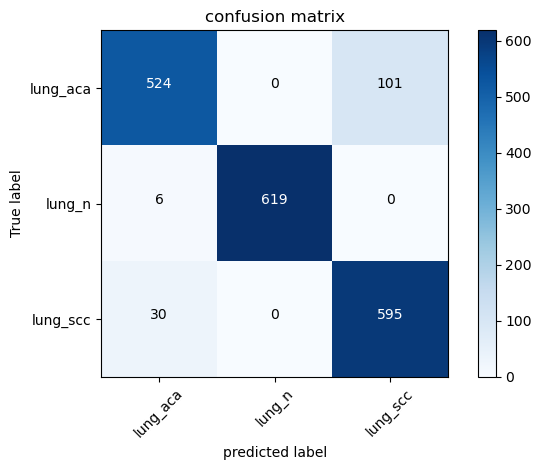

In [41]:
plt_confusion_matrix(cm=cm, classes=hp['class_names'], title="confusion matrix", )